# SystemDeepGalerkin-model: solving systems of PDEs with NN's


Welcome! In this tutorial you'll learn how to solve systems of partial differential equations (PDEs) with neural networks using `SystemDeepGalerkin`-model from `BatchFlow`, inspired by the paper [DGM: A deep learning algorithm for solving partial differential equations](http://arxiv.org/abs/1708.07469).

It is expected for you to be familiar with `DeepGalerkin` model. If you haven't already, check our [DeepGalerkin tutorial](./09_solving_PDE_with_NN.ipynb) to learn how to solve single PDE with neural networks.

**Note**: `SystemDeepGalerkin` is written in [TensorFlow](https://www.tensorflow.org/). Throughout the notebook `tf` will stand for `TensoFlow`.

## Setup of the problem

Currently, `SystemDeepGalerkin` is able to solve system of equations of up to the second order with constant coefficients with various boundary and initial conditions. In most general form, the problem looks as follows:

<a id='eq'></a>
$$
\begin{cases}
\sum_f \Bigg\{ \sum_i a_{mfi} \dfrac{\partial u_{mf}}{\partial x_i} + \sum_{i j} b_{ m f i j} \dfrac{\partial^2 u_{mf}}{\partial x_i \partial x_i} \Bigg\}  = Q_{m}(x), \\ m \in [0 \dots M], \\
\end{cases}
$$

where indices $m, f$ stand for index of equation and unknown function respectively. $M$ is the total number of equations. 

The main idea of `SystemDeepGalerkin`  stays the same: to fit the parameters $\theta$ of network $net(x; \theta)$ so that the difference between left-hand-sides (lhs) and right-hand-size (rhs) is small:
<a id='dist'></a>
$$
e_m(x) = \sum_f \Bigg\{ \sum_i a_{mfi} \dfrac{\partial net(x; \theta)_{f}}{\partial x_i} + \sum_{i j} b_{ m f i j} \dfrac{\partial^2 net(x; \theta)_{f}}{\partial x_i \partial x_i} \Bigg\} - Q_{m}(x),
$$
$$
Loss(\theta) = \int\limits_{\Omega} L\left[\sum_m e_m(x)\right] \mathcal{P}( d x),
$$
$$
Loss(\theta) \rightarrow \min\limits_{\theta}.
$$

The big change from `DeepGalerkin` is that neural network has to have multiple outputs (one for each unknown function).

**Note:** In practice, $Loss(\theta)$ is estimated on a sample(batch) of points $\{(x^i_1,\dots, x^i_n)\}_{i=1,\dots,N}$.
As the distribution $\mathcal{P}$ is not fixed, any sampling scheme can be used.

## Configuring `DeepGalerkin`
As in previous model, configurating `SystemDeepGalerkin` comes to:
* specifying PDE problem via `pde` key
* setting up neural network architecture (and additional parameters)
* configuring how to form batches of training data and feed them into the training loop


### `PDE`-dict
To set up PDE problem, you need to specify:
* coefficients of every equation. That has to be done via `form` key, but unlike `DeepGalerkin`, every value in it has to be `np.array`
* `rhs`: tf_callable. The returned value must be list of appropriate length (same as number of equations)  

There are also optional parameters:
* `domain` for every variable
* `initial_condition`: initial state and initial rate
* `time_multiplier`: can be either string or list of strings. In former case, same `time_multiplier` is applied for binding initial conditions. The latter case corresponds to individual `time_multiplier` strategies. 

### Neural network architecture

As mentioned earlier, `SystemDeepGalerkin` approximates multiple unknown functions via one neural network with multiple outputs. It is easy to see that such neural network can be represented as multiple single-output networks with different layers following some common ones.

To configure model, you have to specify:

* `body`. Parameters of shared part of network. As always, you can use convinient [batchflow's syntax](https://analysiscenter.github.io/batchflow/intro/tf_layers.html). For instance, this combination of keys
```
'body':{'layout' : 'fa fa f',
        'units' : [10, 15, 1],
        'activation' : [tf.nn.tanh, tf.nn.tanh]}
```
corresponds to a `f`ully-connected network with two hidden layers (of 10 and 15 units), one output-unit and two `tanh`-`a`ctivations.

* `head`. Configuration of individual layers for every output.

## Example: solving system of 2 equations with `SystemDeepGalerkin`

In [1]:
import tensorflow as tf
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from batchflow.models.tf import SystemDeepGalerkin
from batchflow import Pipeline, L, F, V, DatasetIndex, Dataset
import numpy as np
from batchflow import NumpySampler
from tqdm import tqdm_notebook

* two equations of the first order with initial conditions:

$$
\begin{cases}
u_1(t) + \dfrac{\partial u_2(t)}{ \partial t} = 0 \\
u_2(t) + \dfrac{\partial u_1(t)}{ \partial t} = 2 \cos(t)
\end{cases}
\\ 
u_1(0)=0, \quad u_2(0)=1.
$$

It is easy to see, that $u_1(t) = \sin(t)$ and $u_2(t) = \cos(t)$ satisfy both system of equations and initial conditions. 

In [2]:
# Setting up shapes of coefficients of left-hand-sides:
# 'M' stands for number of equations
# 'N' stands for number of variables
M, N = 2, 1
d0 = np.zeros((M, M))
d1 = np.zeros((M, M, N))
d2 = np.zeros((M, M, N, N))

# The first index stands for equation number, the second one - for unknown function
d0[0, 0] = 1
d1[0, 1, 0] = 1

d0[1, 1] = 1
d1[1, 0, 0] = 1

# Specifying problem
# Note that both 'rhs' and 'initial_condition' return callable that returns list
# Also, we can use 'polynomial' time_multiplier since we know that solutions have no asymptotes
pde = {'form': {'d0': d0, 'd1': d1, 'd2': d2},
       'rhs': lambda x: [tf.fill(tf.shape(x[:]), 0.0),
                         2*tf.cos(x[:])],
       'initial_condition': lambda x: [tf.constant(0.0, dtype='float32'),
                                       tf.constant(1.0, dtype='float32')],
       'time_multiplier': 'polynomial'}

# Network-architecture and loss-function
# 'body' configures common part for both unknown functions
# 'head' specifies individual branches for every output
body = {'layout': 'fa',
        'units': 40,
        'activation': tf.nn.tanh}

head = {'layout': 'fa fa' + 'f',
        'units': [25, 25, 1],
        'activation': [tf.nn.tanh]*2}

loss = 'mse'

# Put it all together in model-config
config = {'pde': pde,
          'body': body,
          'head': head,
          'loss': loss}  

# Uniform sampling scheme
s = NumpySampler('u', dim=1)

In [7]:
# Assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', SystemDeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# Train the network on batches
for i in tqdm_notebook(range(100)):
    pipeline_ds.next_batch(40, n_epochs=None)

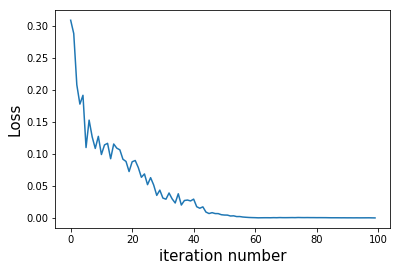

In [8]:
# Plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

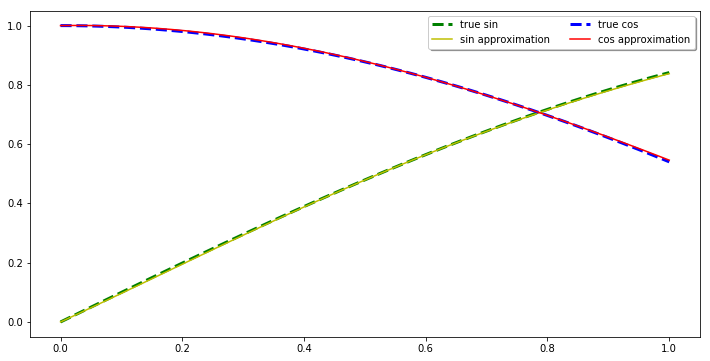

In [9]:
# Fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

# Plot true solutions and their approximations
n_el = 100
fig, ax = plt.subplots(figsize=(12, 6))
pts = np.linspace(0, 1, n_el).reshape((n_el, 1))

true_sin = [np.sin(t_) for t_ in pts]
approxs_sin = dg.predict(feed_dict={'points': pts})[0]
true_cos = [np.cos(t_) for t_ in pts]
approxs_cos = dg.predict(feed_dict={'points': pts})[1]

plt.plot(pts, true_sin, 'g--', linewidth=3, label='true sin')
plt.plot(pts, approxs_sin.reshape(n_el, ), 'y', label='sin approximation')
plt.plot(pts, true_cos, 'b--',  linewidth=3, label='true cos')
plt.plot(pts, approxs_cos.reshape(n_el, ), 'r', label='cos approximation')

ax.legend(loc='upper right', shadow=True, ncol=2)
fig.show()